# Metrics of classification probabilities

TODO: change double float probs to integers, for less space/volume of data, could precompute from binned probabilities, check that it can be done in sql

also check the probabilities sum to 1 at some point
and allow submissions for negative of class
and flags for did not classify and reasons

In [1]:
%matplotlib inline
import sys
import os
import requests
import datetime
import dateutil.parser
import json
import numpy
import pandas
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import sklearn.metrics

In [2]:
 os.getenv("HOME")

'/home/aimalz'

In [3]:
url = "https://desc-tom.lbl.gov"
# url = "https://desc-tom-rknop-dev.lbl.gov"

# Somehow you need to set the "username" and "password" variables.
# Do NOT hardcode the password into any code that will be world
# readable.  You can use the python input statement, or, as I do
# here, read the password from a file that is only readable by
# you.  (This isn't perfect, but it's better than having the
# password sit around in a world readable file.)
username = "aimalz"#"rknop"
with open( os.path.join( os.getenv("HOME"), "secrets", "tom_"+username+"_passwd" ) ) as ifp:
    password = ifp.readline().strip()

In [4]:
rqs = requests.session()
rqs.get( f'{url}/accounts/login/' )
res = rqs.post( f'{url}/accounts/login/',
                data={ "username": username,
                       "password": password,
                       "csrfmiddlewaretoken": rqs.cookies['csrftoken'] } )
if res.status_code != 200:
    raise RuntimeError( f"Failed to log in; http status: {res.status_code}" )
if 'Please enter a correct' in res.text:
    raise RuntimeError( "Failed to log in.  I think.  Put in a debug break and look at res.text" )
rqs.headers.update( { 'X-CSRFToken': rqs.cookies['csrftoken'] } )

In [5]:
def run_query(query, subdict=None):
    if subdict == None:
        subdict = {}
    result = rqs.post( f'{url}/db/runsqlquery/',
        json={ 'query': query, 'subdict': subdict } )
    if result.status_code != 200:
        sys.stderr.write( f"ERROR: got status code {result.status_code} ({result.reason})\n" )
    else:
        data = json.loads( result.text )
        if ( 'status' not in data ) or ( data['status'] != 'ok' ):
            sys.stderr.write( "Got unexpected response\n" )
            print(data['error'])
        else:
            return data['rows']

In [6]:
rows = run_query( 'SELECT "classifierId","brokerName","brokerVersion",'
                  '"classifierName","classifierParams" '
                  'FROM elasticc_brokerclassifier' )
classifier_info = {}
for row in rows:
    classifier_info[row["classifierId"]] = row             
classifier_info

{36: {'classifierId': 36,
  'brokerName': 'AMPEL',
  'brokerVersion': 'v0.2',
  'classifierName': 'ElasticcLiveSNGuess',
  'classifierParams': 'XGBUnified+Parsnip04'},
 37: {'classifierId': 37,
  'brokerName': 'AMPEL',
  'brokerVersion': 'v0.2',
  'classifierName': 'ElasticcLive',
  'classifierParams': 'XGBUnified+Parsnip04'},
 38: {'classifierId': 38,
  'brokerName': 'AMPEL',
  'brokerVersion': 'v0.2',
  'classifierName': 'ElasticcLiveSNGuessParsnip',
  'classifierParams': 'XGBUnified+Parsnip04'},
 39: {'classifierId': 39,
  'brokerName': 'AMPEL',
  'brokerVersion': 'v0.2',
  'classifierName': 'ElasticcLiveSNGuessParsnipPrior',
  'classifierParams': 'XGBUnified+Parsnip04'},
 40: {'classifierId': 40,
  'brokerName': 'ALeRCE',
  'brokerVersion': '3.1.0',
  'classifierName': 'balto',
  'classifierParams': '3.1.0'},
 41: {'classifierId': 41,
  'brokerName': 'ALeRCE',
  'brokerVersion': '1.0.0',
  'classifierName': 'messi',
  'classifierParams': '1.0.0'},
 42: {'classifierId': 42,
  'broke

### select just a couple `classifierID` to inspect

In [7]:
use_cfers = {i: classifier_info[i] for i in [40, 44]}
use_cfers

{40: {'classifierId': 40,
  'brokerName': 'ALeRCE',
  'brokerVersion': '3.1.0',
  'classifierName': 'balto',
  'classifierParams': '3.1.0'},
 44: {'classifierId': 44,
  'brokerName': 'ANTARES',
  'brokerVersion': '2.0.0',
  'classifierName': 'LiCuParsnip_filter',
  'classifierParams': 'v2'}}

In [8]:
rows = run_query( 'SELECT DISTINCT ON ("classId") "classId",description '
                  'FROM elasticc_gentypeofclassid '
                  'ORDER BY "classId"' )
classname = {}
for row in rows:
    classname[row["classId"]] = row["description"]

In [ ]:
classname

## Everything above here is setup.  Run all that.  Then pick and choose below.

In [10]:
# consider descIngestTimestamp, alertSentTimestamp
#
# alertSentTimestamp -- this gets updated in the database when the original
#    alert is sent out.  It's NOT present in the dev database, but should
#    be in the real one
# descIngestTimestamp -- just when we happend to suck in the broker message
#
# alertId -- opaque fingerprint, don't sort on it, but it does correspond to
#   the original alert.  Different alertId = different source, i.e.
#   measurement of the transient.

sys.stderr.write( f"Query start at {datetime.datetime.now().isoformat()}...\n" )
query = ( 'SELECT '
          '  "classifierId","diaObjectId","classId","alertId","trueClassId","probability","descIngestTimestamp" '
          'FROM elasticc_view_sourceclassifications '
          'ORDER BY "diaObjectId","descIngestTimestamp","classifierId" '
          'OFFSET 100 LIMIT 100' )
rows = run_query( query )
sys.stderr.write( f"Query done at {datetime.datetime.now().isoformat()}\n" )
data = pandas.DataFrame( rows )
data
# classifiers = data.classifierId.unique()

Query start at 2023-01-07T13:50:21.153647...
Query done at 2023-01-07T13:50:21.614187


,classifierId,diaObjectId,classId,alertId,trueClassId,probability,descIngestTimestamp
0,40,1000009,115,2000018241,214,1.524055e-16,2022-12-25T12:17:29.752Z
1,40,1000009,111,2000018241,214,1.680303e-15,2022-12-25T12:17:29.752Z
2,40,1000009,114,2000018241,214,1.141596e-15,2022-12-25T12:17:29.752Z
3,40,1000009,112,2000018241,214,5.137730e-16,2022-12-25T12:17:29.752Z
4,40,1000009,113,2000018241,214,4.103487e-14,2022-12-25T12:17:29.752Z
...,...,...,...,...,...,...,...
95,42,1000009,220,2000018241,214,0.000000e+00,2022-12-26T08:35:18.873Z
96,42,1000009,120,2000018241,214,0.000000e+00,2022-12-26T08:35:18.873Z
97,42,1000009,130,2000018241,214,0.000000e+00,2022-12-26T08:35:18.873Z
98,87,1000009,21,2000018241,214,1.000000e+00,2022-12-27T08:35:28.524Z


TODO: change double float probs to integers, for less space/volume of data
also check the probabilities sum to 1 at some point
and allow submissions for negative of class
and flags for did not classify and reasons

In [11]:
sys.stderr.write( f"Query start at {datetime.datetime.now().isoformat()}...\n" )
query = ( 'SELECT '
          '  "classifierId","diaObjectId","classId","alertId","trueClassId","probability","descIngestTimestamp","alertSentTimestamp" '
          'FROM elasticc_view_sourceclassifications '
          'WHERE "classifierId"=41 '#' AND "classId"=111 AND "trueClassId"=111 '
          'ORDER BY "diaObjectId","descIngestTimestamp" '
          'OFFSET 1000 LIMIT 1000' )
rows = run_query( query )
sys.stderr.write( f"Query done at {datetime.datetime.now().isoformat()}\n" )
data = pandas.DataFrame( rows )
data

Query start at 2023-01-07T13:50:21.659517...
Query done at 2023-01-07T13:50:22.748778


,classifierId,diaObjectId,classId,alertId,trueClassId,probability,descIngestTimestamp,alertSentTimestamp
0,41,1000487,130,2000974029,112,0.000000e+00,2022-11-17T23:22:45.883Z,2022-11-17T21:01:46.097Z
1,41,1000487,221,2000974029,112,3.998851e-06,2022-11-17T23:22:45.883Z,2022-11-17T21:01:46.097Z
2,41,1000487,134,2000974029,112,2.967518e-07,2022-11-17T23:22:45.883Z,2022-11-17T21:01:46.097Z
3,41,1000487,211,2000974029,112,1.770257e-08,2022-11-17T23:22:45.883Z,2022-11-17T21:01:46.097Z
4,41,1000487,213,2000974029,112,8.146125e-14,2022-11-17T23:22:45.883Z,2022-11-17T21:01:46.097Z
...,...,...,...,...,...,...,...,...
995,41,1000872,214,2001744010,113,5.679732e-06,2022-09-30T17:58:06.750Z,2022-09-29T22:55:10.721Z
996,41,1000872,123,2001744010,113,3.378398e-05,2022-09-30T17:58:06.750Z,2022-09-29T22:55:10.721Z
997,41,1000872,213,2001744010,113,1.208563e-04,2022-09-30T17:58:06.750Z,2022-09-29T22:55:10.721Z
998,41,1000872,211,2001744010,113,4.407149e-07,2022-09-30T17:58:06.750Z,2022-09-29T22:55:10.721Z


### choose one `diaObjectID` for inspection

In [12]:
returned = np.unique(data['diaObjectId'], return_counts=True)

In [13]:
by_richness = returned[0][np.argsort(returned[1])]
chosen = by_richness[3]
# data[data['diaObjectId'] == chosen]

In [14]:
# chosen = richest#np.unique(data['diaObjectId'], return_counts=True)[0][4]#1006052#1003722
one_obj_data = data[ data['diaObjectId'] == chosen]#1025381 ]
one_obj_true = one_obj_data['trueClassId'][0]
# one_obj_data

In [15]:
# All these joins suggest we need a new view.
sys.stderr.write( f"Query start at {datetime.datetime.now().isoformat()}...\n" )
query = ( 'SELECT '
          '  v."classifierId",v."diaObjectId",v."classId",v."alertId",v."trueClassId",v."probability",v."alertSentTimestamp", '
          '  s."midPointTai" '
          'FROM elasticc_view_sourceclassifications v '
          'INNER JOIN elasticc_diasource s ON v."diaSourceId"=s."diaSourceId" '
          f'WHERE v."diaObjectId"= {chosen} AND "classId"={one_obj_true} AND "trueClassId"={one_obj_true} '
          'ORDER BY "classifierId","alertSentTimestamp" ' )
rows = run_query( query )
sys.stderr.write( f"Query done at {datetime.datetime.now().isoformat()}\n" )
join_one_obj_data = pandas.DataFrame( rows )
# join_one_obj_data

Query start at 2023-01-07T13:50:22.791418...
Query done at 2023-01-07T13:50:23.405375


In [16]:
pandas.set_option('display.max_rows', 500)
join_one_obj_data['t'] = join_one_obj_data['alertSentTimestamp'].apply( lambda thing : dateutil.parser.isoparse( thing ) )
join_one_obj_data.columns

Index(['classifierId', 'diaObjectId', 'classId', 'alertId', 'trueClassId',
       'probability', 'alertSentTimestamp', 'midPointTai', 't'],
      dtype='object')

In [17]:
# classifier_info

In [18]:
# for i,cfer in enumerate(classifiers):
#     print(cfer,classifier_info[cfer]["brokerName"],classifier_info[cfer]["classifierName"],classifier_info[cfer]["brokerVersion"])

In [19]:
blind = False

In [20]:
    
# # TODO: color for broker, linestyle for classifier

# fig = plt.figure( figsize=(12,8), tight_layout=True )
# ax = fig.add_subplot( 1,1,1)
# classifiers = data['classifierId'].unique()
# for i,cfer in enumerate(use_cfers):
#     subdata = join_one_obj_data[ join_one_obj_data['classifierId'] == cfer ]
#     label = f'{use_cfers[cfer]["brokerName"]} {use_cfers[cfer]["classifierName"]}'
#     ax.plot( subdata['midPointTai'], subdata['probability'], color=f'C{i}', label=label )
#     ax.tick_params( "both", labelsize=16 )
# if ~blind:
#     ax.legend()
#     ax.set_title('diaObjectID='+str(chosen))#"Jackson Pollock" )
# ax.set_xlabel('midPointTai (time)', fontsize=16)
# ax.set_ylabel('probability of true class', fontsize=16)
# fig.show()

1. metric as f(time relative to characteristic time) -- TODO: ask Rick for characteristic times/scalings for all classes, should be in object truth table in the future
2. metric as f(number of alerts)



In [21]:
# def flux_to_mag(flux):
#     fluxmod = flux

In [22]:
# chosen = np.unique(data['diaObjectId'], return_counts=True)[0][1]

In [23]:
sys.stderr.write( f"Query start at {datetime.datetime.now().isoformat()}...\n" )
query = ( 'SELECT '
         ' "midPointTai", "psFlux", "psFluxErr", "filterName" '
         'FROM "elasticc_diaforcedsource" '
         f'WHERE "diaObjectId" = {chosen}'
         'ORDER BY "midPointTai"' )
rows = run_query( query )
sys.stderr.write( f"Query done at {datetime.datetime.now().isoformat()}\n" )
test_lc = pandas.DataFrame( rows )
# test_lc

Query start at 2023-01-07T13:50:23.530361...
Query done at 2023-01-07T13:50:23.850700


In [24]:
# test_lc

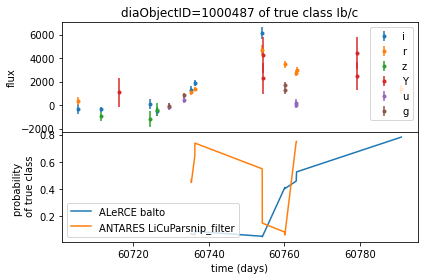

In [25]:
blind = False

fig, ax = plt.subplots(2, 1, sharex=True)
for i,band in enumerate(test_lc['filterName'].unique()):
    one_band = test_lc[test_lc['filterName'] == band]
    ax[0].errorbar(one_band['midPointTai'], one_band['psFlux'], yerr=one_band['psFluxErr'], 
                   fmt="o", markersize=3, label=band)
#     ax[i].set_title(band)
# fig.legend()
ax[0].set_ylabel('flux')
ax[0].legend()

# fig = plt.figure( figsize=(12,8), tight_layout=True )
# ax = fig.add_subplot( 1,1,1)
classifiers = join_one_obj_data['classifierId'].unique()
for i,cfer in enumerate(use_cfers):
    subdata = join_one_obj_data[ join_one_obj_data['classifierId'] == cfer ]
    label = f'{use_cfers[cfer]["brokerName"]} {use_cfers[cfer]["classifierName"]}'
    ax[1].plot(subdata['midPointTai'], subdata['probability'], color=f'C{i}', label=label )
#     ax[1].tick_params( "both", labelsize=16 )
if ~blind:
    ax[1].legend(loc='lower left')
    ax[0].set_title('diaObjectID='+str(chosen)+' of true class '+classname[one_obj_true])#"Jackson Pollock" )
# ax[6].set_title('midPointTai (time)', fontsize=16)
ax[1].set_ylabel('probability \n of true class')#, fontsize=16)
ax[1].set_xlabel('time (days)')
# fig.show()
# ax[0].set_title(str(chosen))

fig.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig(str(chosen)+'jointplot.png', dpi=300, bbox_inches='tight', pad_inches=0)

In [ ]:
# # Oh, the humanity
# sys.stderr.write( f"Query start at {datetime.datetime.now().isoformat()}...\n" )
# query = ( 'SELECT '
#           '  v."classifierId",v."diaObjectId",v."classId",v."alertId",v."probability",v."alertSentTimestamp", '
#           '  s."midPointTai",t.peakmjd '
#           'FROM elasticc_view_sourceclassifications v '
#           'INNER JOIN elasticc_diasource s ON v."diaSourceId"=s."diaSourceId" '
#           'INNER JOIN elasticc_diaobjecttruth t ON v."diaObjectId"=t."diaObjectId" '
#           'WHERE v."diaObjectId" IN '
#           '  ( SELECT "diaObjectId" FROM elasticc_diaobjecttruth WHERE gentype IN '
#           '     ( SELECT gentype FROM elasticc_gentypeofclassid WHERE "classId"=111 ) '
#           '    LIMIT 100 ) '
#           'AND "classId"=111 '
#           'ORDER BY "classifierId","alertSentTimestamp" ' )
# rows = run_query( query )
# sys.stderr.write( f"Query done at {datetime.datetime.now().isoformat()}\n" )
# data = pandas.DataFrame( rows )
# data

In [ ]:
# data['Δt'] = data['midPointTai'] - data['peakmjd']
# data

In [ ]:
# onebroker = data[ data['classifierId'] == 40 ].copy()

In [ ]:
# onebroker

In [ ]:
# plt.hist( onebroker['Δt'] )

In [ ]:
# # This is not the right way to bin.  We have to think harder about this.
# # If there are more observations of some objectds, those objects will
# # get overweighted.
# onebroker['tbin'] = numpy.floor( ( onebroker['Δt'] + 20 ) / 5. )

In [ ]:
# thing = onebroker.groupby( 'tbin' )['probability'].apply( 'mean' )

In [ ]:
# plt.plot(thing)

In [ ]:
# tuple(use_cfers.keys())

## New Query, Alex and Rob, 2022-12-15, Waiting For A Better Title

In [ ]:
sys.stderr.write( f"Query start at {datetime.datetime.now().isoformat()}...\n" )
query = ( 'SELECT '
          '  v."classifierId",v."diaObjectId",v."classId",v."alertId",v."trueClassId",v."probability",v."alertSentTimestamp", '
          '  s."midPointTai"-ot.peakmjd AS deltat '
          'FROM elasticc_view_sourceclassifications v '
          'INNER JOIN elasticc_diasource s ON v."diaSourceId"=s."diaSourceId" '
          'INNER JOIN elasticc_diaobjecttruth ot ON v."diaObjectId"=ot."diaObjectId" '
          f'WHERE "classifierId" IN %(cfers)s AND "trueClassId"={one_obj_true} '
          'ORDER BY "diaObjectId","alertSentTimestamp" '
          'LIMIT 10000' )
rows = run_query( query, { 'cfers': tuple(use_cfers.keys()) } )
sys.stderr.write( f"Query done at {datetime.datetime.now().isoformat()}\n" )
data = pandas.DataFrame( rows )
data

In [ ]:
pre_probvecs = data.groupby(['alertId', "classifierId"])
probvecs = data.set_index(['diaObjectId', "classifierId"])
# for idno in data['classId'].unique():
#     probvecs[str(idno)] = data['classId'=]
probvecs

In [ ]:
probvecs.index.levels[0]

In [ ]:
type(plot_one)

In [ ]:
tmp_xs

In [ ]:
to_plot = []
for objectids in probvecs.index.levels[0][3:4]:
    for classifierids in probvecs.index.levels[1]:
        tmp_xs = probvecs.xs((objectids, classifierids)).reset_index()[['deltat', 'classId', 'bin_prob']]
        plot_one = pandas.pivot_table(tmp_xs, 
                                      values='bin_prob',
                                      columns='classId',
                                     index='deltat')
        seaborn.heatmap(plot_one)
        plt.show()
        
# plt.matshow(plot_one)

Next: bin the times, average values within time bin for same true type, gif of plasticc results fig 9 over time

In [ ]:
help(pandas.pivot_table)

In [ ]:
plot_one

In [ ]:
import seaborn

TODO: 

In [ ]:
plot_one.pivot_table?

In [ ]:
# import matplotlib as mpl
# from matplotlib import cm
plt.scatter(plot_one['alertId'], plot_one['classId'], s=100*plot_one['bin_prob'])

In [ ]:
data['diaObjectId'].unique()

In [ ]:
plt.hist(data['classId'])

In [ ]:
data["bin_prob"] = data['probability'].round(decimals=2)

voila they sum to 1!

In [ ]:
data.groupby(['alertId', "classifierId"])["probability"].sum()